<a href="https://colab.research.google.com/github/massifcoder/assignment/blob/main/majorProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
A siamese neural network (SNN) is a class of neural network architectures that contain two or more identical sub-networks. “Identical” here means they have the same configuration with the same parameters and weights. Parameter updating is mirrored across both sub-networks and it’s used to find similarities between  inputs by comparing its feature vectors.

In this project, we will use triplet loss funciton to ensure that embeddings of similar instances (e.g., images of the same person) are closer together in the embedding space, while embeddings of dissimilar instances (e.g., images of different people) are farther apart.

L=max( ∥ f (A) − f(P)∥2 − ∥f(A) − f(N) ∥ 2+α, 0)

We will install all necessary modules necessary for further functioning

In [1]:
!pip install --upgrade tensorflow


import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import layers, losses, optimizers, metrics, Model
from tensorflow.keras.applications import ResNet50

# Define target image shape
target_shape = (200, 200)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found e

In [2]:
from pathlib import Path

cache_dir = Path(Path.home()) / ".keras"
anchor_images_path = cache_dir / "left"
positive_images_path = cache_dir / "right"


In [3]:
!gdown --id 1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
!gdown --id 1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
!unzip -oq left.zip -d $cache_dir
!unzip -oq right.zip -d $cache_dir

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
From (redirected): https://drive.google.com/uc?id=1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34&confirm=t&uuid=e1c99953-35df-4cd5-9489-9c72832e58b4
To: /content/left.zip
100% 104M/104M [00:00<00:00, 144MB/s] 
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
From (redirected): https://drive.google.com/uc?id=1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW&confirm=t&uuid=597a93bb-e756-48f0-8496-a77104fede67
To: /content/right.zip
100% 104M/104M [00

To make sure both anchor images and positive images load sorted, we will sort this data.

These lines of code are creating TensorFlow datasets from lists of file paths (anchor_images and positive_images). Let me break it down:

  # tf.data.Dataset.from_tensor_slices(anchor_images)
   This line creates a TensorFlow dataset from a list of file paths anchor_images. Each element in the dataset will correspond to one file path in the list. This means that each element of the dataset will be a string representing the file path to an anchor image.

  # tf.data.Dataset.from_tensor_slices(positive_images):
   Similarly, this line creates another TensorFlow dataset from a list of file paths positive_images. Each element in this dataset will correspond to one file path in the list, representing a positive image.

After executing these lines, you will have two TensorFlow datasets: anchor_dataset and positive_dataset. Each dataset will contain file paths to anchor images and positive images, respectively. These datasets can then be used for further processing, such as loading images, preprocessing, and training a machine learning model.

In [4]:
# Sorting and loading file paths.
anchor_file_names = os.listdir(anchor_images_path)
positive_file_names = os.listdir(positive_images_path)

anchor_file_names.sort()
positive_file_names.sort()

anchor_images = [str(anchor_images_path / f) for f in anchor_file_names]
positive_images = [str(positive_images_path / f) for f in positive_file_names]

# Creating two network architectures.
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

# Now, to make sure that our data is random in every sequence, we will randomise it.
rng = np.random.RandomState(seed=42) # random state is fixed and 42.
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

# Concatenate the shuffled lists to generate the list of negative images
negative_images = anchor_images + positive_images

# Shuffle the list of negative images
rng = np.random.RandomState(seed=32)
rng.shuffle(negative_images)

# Create a TensorFlow dataset from the shuffled list of negative images
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)

# Processing the image and triplets

In [5]:
def preprocess_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


# Processing the triplet
def preprocess_triplets(anchor, positive, negative):
    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

# Spliting the dataset of triplets into training and validation subsets and batches the training and validation datasets into batches of size 32.

In [6]:
image_count = len(anchor_images)
train_size = int(0.8*image_count)

train_anchor_dataset = anchor_dataset.take(train_size)
train_positive_dataset = positive_dataset.take(train_size)
train_negative_dataset = negative_dataset.take(train_size)

val_anchor_dataset = anchor_dataset.skip(train_size)
val_positive_dataset = positive_dataset.skip(train_size)
val_negative_dataset = negative_dataset.skip(train_size)

train_dataset = tf.data.Dataset.zip((train_anchor_dataset, train_positive_dataset, train_negative_dataset))
val_dataset = tf.data.Dataset.zip((val_anchor_dataset, val_positive_dataset, val_negative_dataset))

train_dataset = train_dataset.shuffle(buffer_size=1024)
val_dataset = val_dataset.shuffle(buffer_size=1024)

train_dataset = train_dataset.map(preprocess_triplets)
val_dataset = val_dataset.map(preprocess_triplets)

train_dataset = train_dataset.batch(32, drop_remainder=False).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32, drop_remainder=False).prefetch(tf.data.AUTOTUNE)


# Example of the dataset. ( Visualisation )

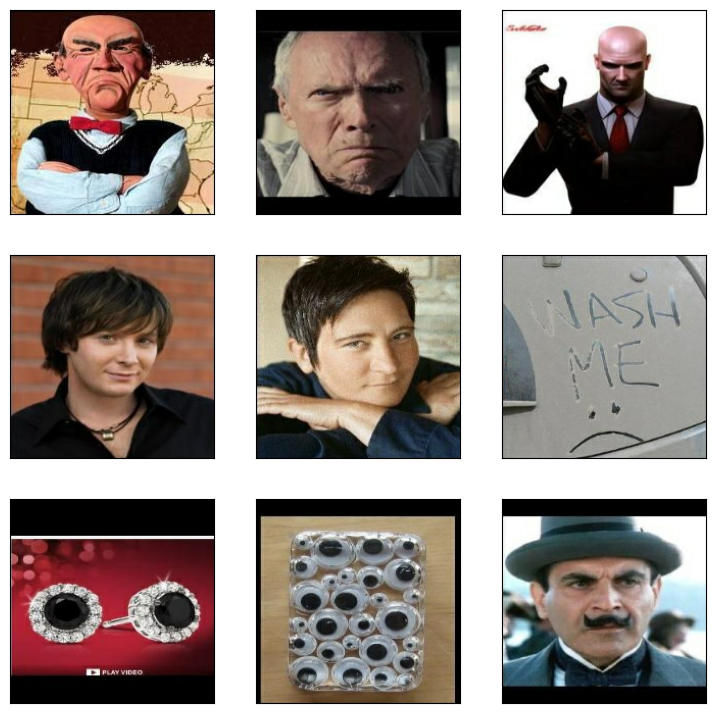

In [7]:
def example(anchor, positive, negative):
    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


example(*list(train_dataset.take(1).as_numpy_iterator())[0])

Our Siamese Network will produce embeddings for each image within the triplet. To achieve this, we'll employ a pre-trained ResNet50 model, which has been trained on the ImageNet dataset. We'll then append several Dense layers to it, enabling us to learn to differentiate between these embeddings.

To preserve the learned weights of the model, we'll freeze all layers up to and including the conv5_block1_out layer. This is crucial to prevent interference with the pre-existing weights. We'll keep the lower layers trainable, allowing us to fine-tune their weights as needed during training.

In [ ]:
base_cnn = ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")


# Setting up the model.
The Siamese network will take each image from the triplet as input, produce the embeddings, and calculate the distances between the anchor and positive embeddings, as well as between the anchor and negative embeddings.

For distance computation, we'll utilize a custom layer called DistanceLayer, which will output both distances as a tuple.


In [9]:
# Declaring the class of distance layer.
class DistanceLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
      ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
      an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
      return (ap_distance, an_distance)

anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

# Compute distances using the DistanceLayer
distances = DistanceLayer()(
    embedding(tf.keras.applications.resnet.preprocess_input(anchor_input)),
    embedding(tf.keras.applications.resnet.preprocess_input(positive_input)),
    embedding(tf.keras.applications.resnet.preprocess_input(negative_input)),
)

# Define the Siamese model
siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [ ]:
class SiameseModel(Model):
    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]

    def get_grad_cam(self, inputs):
      with tf.GradientTape() as tape:
          # Forward pass
          ap_distance, _ = self.siamese_network(inputs)
          last_conv_layer_output = self.siamese_network.get_layer('Embedding').output
          grads = tape.gradient(ap_distance, last_conv_layer_output)
          pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
      heatmap = last_conv_layer_output.numpy() * pooled_grads.numpy()[..., np.newaxis]
      heatmap = np.sum(heatmap, axis=-1)
      heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
      return heatmap

# Training of the data. In our dataset, we have divided the data in 80:20 ratio.
80% of the data will be trained and 20% of data will be used for testing.

In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=1, validation_data=val_dataset)

  1/151 ━━━━━━━━━━━━━━━━━━━━ 6:07:25 147s/step - loss: 1.3340

In [ ]:
sample = next(iter(train_dataset))
example(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(tf.keras.applications.resnet.preprocess_input(anchor)),
    embedding(tf.keras.applications.resnet.preprocess_input(positive)),
    embedding(tf.keras.applications.resnet.preprocess_input(negative)),
)

Finally, we can compute the cosine similarity between the anchor and positive
images and compare it with the similarity between the anchor and the negative
images.

We should expect the similarity between the anchor and positive images to be
larger than the similarity between the anchor and the negative images.

In [ ]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())


# Grad Cam and Taining color encoder.

In [ ]:
def train_color_encoder(X1, X2, y):
    # Color Encoder
    input_layer = Input((28, 28, 3))
    layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
    layer2 = MaxPooling2D((2, 2), padding='same')(layer1)
    layer3 = Conv2D(8, (3, 3), activation='relu', padding='same')(layer2)
    layer4 = MaxPooling2D((2, 2), padding='same')(layer3)
    layer5 = Flatten()(layer4)
    embeddings = Dense(16, activation=None)(layer5)
    norm_embeddings = Lambda(lambda x: tf.nn.l2_normalize(x, axis=-1))(embeddings)  # Normalize embeddings

    # Create model
    model = Model(inputs=input_layer, outputs=norm_embeddings)

    # Create siamese model
    input1 = Input((28, 28, 3))
    input2 = Input((28, 28, 3))

    # Create left and right twin models
    left_model = model(input1)
    right_model = model(input2)

    # Dot product layer
    dot_product = Dot(axes=1, normalize=False)([left_model, right_model])

    siamese_model = Model(inputs=[input1, input2], outputs=dot_product)

    # Model summary
    print(siamese_model.summary())

    # Compile model
    siamese_model.compile(optimizer='adam', loss='mse')

    # Grad-CAM
    conv_layer = Conv2D(64, (3, 3), activation='relu', padding='same', name="final_conv_layer")(input1)
    gap_layer = GlobalAveragePooling2D()(conv_layer)
    output_layer = Dense(1)(gap_layer)
    cam_model = Model(inputs=input1, outputs=output_layer)

    # Plot model diagrams
    plot_model(siamese_model, to_file='siamese_model_mnist.png', show_shapes=True, show_layer_names=True)
    plot_model(cam_model, to_file='grad_cam_model.png', show_shapes=True, show_layer_names=True)

    # Display the flowchart images
    img1 = plt.imread('siamese_model_mnist.png')
    plt.imshow(img1)
    plt.title('Siamese Model')
    plt.axis('off')
    plt.show()

    img2 = plt.imread('grad_cam_model.png')
    plt.imshow(img2)
    plt.title('Grad-CAM Model')
    plt.axis('off')
    plt.show()

    return model, cam_model

# Call the train_color_encoder function with your dataset
trained_color_encoder, trained_cam_model = train_color_encoder(anchor_images, positive_images, negative_images)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

def grad_cams(model, image, cls, layer_name):
    gradModel = Model(
    inputs=model.input,
    outputs=[model.get_layer(layer_name).output, model.output]
    )


    with tf.GradientTape() as tape:
        inputs = tf.cast(image, tf.float32)
        (convOutputs, predictions) = gradModel([inputs])
        loss = predictions[:, 0]

    grads = tape.gradient(loss, convOutputs)
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    eps = 1e-8
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    return heatmap

In [ ]:
# Grad cam on anchor images
anchor_sample_image_path = anchor_images[0]
image = cv2.imread(anchor_sample_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.astype(np.float32)
image_resized = cv2.resize(image, (28, 28))
image_resized_expanded = np.expand_dims(image_resized, axis=0)
heatmap = grad_cams(trained_cam_model, image_resized_expanded, 0, 'final_conv_layer')

# Display the original image and overlay the heatmap
plt.imshow(image)  # Display the original image
plt.imshow(heatmap, alpha=0.5, cmap='jet')  # Overlay the heatmap on the image
plt.axis('off')
plt.show()

In [ ]:

# Assuming negative_images contains the images
negative_sample_image_path = negative_images[0]
image = cv2.imread(negative_sample_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.astype(np.float32)
image_resized = cv2.resize(image, (28, 28))
image_resized_expanded = np.expand_dims(image_resized, axis=0)
heatmap = grad_cams(trained_cam_model, image_resized_expanded, 0, 'final_conv_layer')

# Display the original image and overlay the heatmap
plt.imshow(image)  # Display the original image
plt.imshow(heatmap, alpha=0.5, cmap='jet')  # Overlay the heatmap on the image
plt.axis('off')
plt.show()

In [ ]:

# Assuming positive_images contains the images
positive_sample_image_path = anchor_images[0]
image = cv2.imread(positive_sample_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.astype(np.float32)
image_resized = cv2.resize(image, (28, 28))
image_resized_expanded = np.expand_dims(image_resized, axis=0)
heatmap = grad_cams(trained_cam_model, image_resized_expanded, 0, 'final_conv_layer')

# Display the original image and overlay the heatmap
plt.imshow(image)  # Display the original image
plt.imshow(heatmap, alpha=0.5, cmap='jet')  # Overlay the heatmap on the image
plt.axis('off')
plt.show()

# kernel Shap

In [ ]:
!pip install --upgrade shap

import shap

In [ ]:
import shap
from tensorflow.keras.models import Model
import numpy as np

def kernel_shap_heatmap(model, image, cls=None, layer_name='final_conv_layer', explainer_type='permutation', num_features=None, max_evals=5000):
    def get_conv_layer_output(inputs):
        intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
        return intermediate_layer_model(inputs)

    if not num_features:
        input_shape = model.input_shape[1:]
        num_features = np.prod(input_shape)

    min_max_evals = 5000

    if max_evals < 2 * num_features + 1:
        print(f"Warning: max_evals is less than the minimum required value. Setting it to {2 * num_features + 1}.")
        max_evals = 2 * num_features + 1

    explainer = shap.Explainer(get_conv_layer_output, model, max_evals=max(max_evals, min_max_evals))

    if not isinstance(image, np.ndarray):
        image = np.array([image])

    if explainer_type == 'permutation':
        try:
            shap_values = explainer.shap_values(image, max_evals=max(max_evals, min_max_evals))
        except TypeError:
            print("Warning: Could not set max_evals in shap_values. Using explainer default.")
            shap_values = explainer.shap_values(image)
    elif explainer_type == 'kernel':
        shap_values = explainer.shap_values(image, algorithm='kernel')
    elif explainer_type == 'deep':
        shap_values = explainer.shap_values(image, algorithm='deep')
    else:
        raise ValueError(f"Invalid explainer_type: {explainer_type}. Choose 'permutation', 'kernel', or 'deep'.")

    shap.summary_plot(shap_values, image)

heatmap = kernel_shap_heatmap(trained_cam_model, image_resized_expanded, 0, 'final_conv_layer', explainer_type='permutation', num_features=20, max_evals=5000)
